# Setup

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [3]:
xb = np.load('pred/feats_train.npy')
yb = np.load('pred/targs_train.npy')
xq = np.load('pred/feats_valid.npy')
yq = np.load('pred/targs_valid.npy')

In [4]:
xb.shape # nb-by-d

(57520, 512)

In [5]:
xq.shape # nq-by-d (query vectors)

(15476, 512)

In [6]:
yb.shape, yq.shape

((57520,), (15476,))

In [7]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 959)

In [8]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [9]:
xb.max()

202.23051

In [10]:
faiss.normalize_L2(xb)

In [11]:
xb.max()

0.21489601

In [12]:
index.train(xb)

In [13]:
index.add_with_ids(xb, yb)

In [14]:
print(index.is_trained)
print(index.ntotal)

True
57520


## Train dataset

In [15]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[ 43 336  87 175  81]
 [510 510 510 510 510]
 [867 867 867 867 867]
 [471 471 471 471 471]
 [570 570 570 570 570]]
[[ 43]
 [510]
 [867]
 [471]
 [570]]
[[1.         0.81108683 0.77457654 0.7459184  0.7456554 ]
 [0.9999998  0.8857346  0.8675618  0.8077924  0.8055785 ]
 [0.99999994 0.8942792  0.85479426 0.85261047 0.8503552 ]
 [1.         0.91290754 0.90923995 0.88616705 0.8733121 ]
 [1.0000002  0.7095337  0.70319307 0.679577   0.6778779 ]]


In [16]:
yb.max(), I_train.max()

(1107, 1107)

### Train accuracy

In [17]:
I_train[:,0].shape, yb.shape

((57520,), (57520,))

In [18]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

1.0

In [19]:
I_train[:10,0], yb[:10]

(array([ 43, 510, 867, 471, 570,  52, 809, 138, 344, 947]),
 array([ 43, 510, 867, 471, 570,  52, 809, 138, 344, 947]))

In [20]:
I_train[-10:,0], yb[-10:]

(array([749, 147, 382, 614, 157, 367,  97, 342, 748, 851]),
 array([749, 147, 382, 614, 157, 367,  97, 342, 748, 851]))

### Train confusion matrix

In [23]:
#cm = confusion_matrix(I_train[:,0], yb)

In [24]:
#fig, ax = plt.subplots(figsize=(15,15))
#ax.matshow(cm, cmap='hot')

## Valid dataset

In [25]:
xq.max()

171.83315

In [26]:
faiss.normalize_L2(xq)

In [27]:
xq.max()

0.21886663

In [28]:
D_valid, I_valid = index.search(xq, k) # actual search

In [29]:
xq.shape, yq.shape

((15476, 512), (15476,))

In [30]:
I_valid.shape, D_valid.shape

((15476, 5), (15476, 5))

In [31]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[ 352  793  352  523   46]
 [ 361  360  360  361   10]
 [1106 1106 1106 1106 1106]
 [ 350  350  162  350  350]
 [1066  445  775  445 1056]]
[[352]
 [361]
 [503]
 [505]
 [ 70]]
[[0.6572956  0.6314259  0.6172898  0.61611664 0.5708819 ]
 [0.65016246 0.64387226 0.6356674  0.6302463  0.6026955 ]
 [0.72069895 0.70018566 0.62134063 0.6096857  0.59808016]
 [0.6981178  0.67748636 0.67025244 0.6608063  0.65084314]
 [0.6919063  0.67569804 0.66373646 0.6550413  0.60057384]]


In [32]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[ 596   23  596  596  596]
 [ 202 1010   71  202  107]
 [ 356  356  778  356  356]
 [ 568  440  304  589 1055]
 [ 663  663   18  663  693]]
[[103]
 [202]
 [824]
 [328]
 [509]]
[[0.83219475 0.7851266  0.7740926  0.73338234 0.7291837 ]
 [0.73527706 0.7012317  0.67090875 0.64856845 0.63872683]
 [0.6714405  0.6683119  0.6379094  0.5992825  0.58039737]
 [0.83053493 0.79692143 0.79622126 0.7927133  0.7865474 ]
 [0.72053874 0.7173817  0.6978879  0.6918606  0.62435234]]


In [33]:
np.save('pred/preds_valid.npy', I_valid)

### Valid accuracy

In [34]:
I_valid[:,0]

array([ 352,  361, 1106, ...,  356,  568,  663])

In [35]:
yq

array([352, 361, 503, ..., 824, 328, 509])

In [36]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

6381

In [37]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.4123158438873094

In [38]:
valid_correct = np.equal(I_valid[:,0], yq)

In [39]:
valid_correct

array([ True,  True, False, ..., False, False, False])

In [40]:
np.save('pred/preds_valid_correct.npy', valid_correct)

### Valid confusion matrix

In [41]:
cm = confusion_matrix(I_valid[:,0], yq)

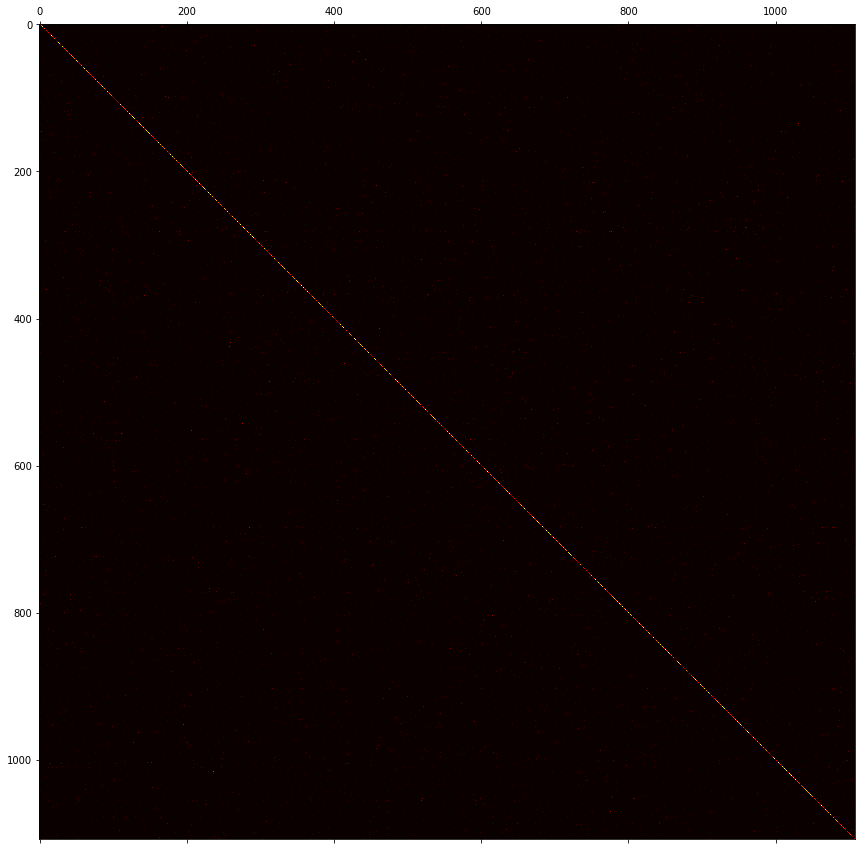

In [42]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Work in progress

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

1506

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

6232

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.19462393383303178

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [43]:
xq_test = np.load('pred/feats_test.npy')

In [44]:
xq_test.max()

227.12695

In [45]:
faiss.normalize_L2(xq_test)

In [46]:
xq_test.max()

0.2251298

In [47]:
D_test, I_test = index.search(xq_test, k) # actual search

In [48]:
xq_test.shape, I_test.shape, D_test.shape

((39794, 512), (39794, 5), (39794, 5))

In [49]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[ 855  855  855  855  591]
 [ 785   79   31  785  785]
 [1009 1009 1009 1009  152]
 [  97  899  771  899  354]
 [ 771  771  904  904  771]]
[[0.8593994  0.84243226 0.8297908  0.82860184 0.8279071 ]
 [0.72640806 0.70245856 0.68102276 0.64014864 0.5924783 ]
 [0.7230113  0.67236257 0.66528845 0.6460186  0.6371616 ]
 [0.7482806  0.7053777  0.67669165 0.67525446 0.67345685]
 [0.7889084  0.74686366 0.7456974  0.73473334 0.7058952 ]]


In [50]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[338 338 338 338 316]
 [338 338 338 338 338]
 [800 800 800 800 490]
 [ 96  96  96  96  96]
 [422 422 422 422 422]]
[[0.61412936 0.6127654  0.6102449  0.60929453 0.5857837 ]
 [0.68899596 0.64647615 0.64636207 0.62840927 0.616302  ]
 [0.68802446 0.66512233 0.64981055 0.63989115 0.63494766]
 [0.67634296 0.66458267 0.64859915 0.6381101  0.6309695 ]
 [0.6882895  0.6827939  0.6708987  0.6704026  0.66284865]]


In [51]:
I_test[2]

array([1009, 1009, 1009, 1009,  152])

In [52]:
np.unique(I_test[2], return_counts=True)

(array([ 152, 1009]), array([1, 4]))

In [53]:
preds_test = I_test[:,0]
dist_test = D_test[:,0]

In [54]:
np.save('pred/preds_test.npy', preds_test)
np.save('pred/dist_test.npy', dist_test)

#### Get mode or most similiar if mode is 1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html#scipy.stats.mode

**This seems to not increase the accuracy !!!**

In [27]:
from scipy import stats

In [28]:
# get mode and mode count
I_test_mode = stats.mode(I_test, axis=1)

In [29]:
I_test.shape, I_test_mode[0].shape

((39794, 5), (39794, 1))

In [30]:
I_test[:5]

array([[ 591,  591,  587,  591,  855],
       [ 736,  770,  387,  728,  933],
       [ 179,  576,  191,  451, 1076],
       [ 908,  908,  609,  256,  892],
       [ 775,  445,  970,  387,  307]])

In [31]:
I_test_mode[0][:5]

array([[591],
       [387],
       [179],
       [908],
       [307]])

In [32]:
I_test_mode[1][:5]

array([[3],
       [1],
       [1],
       [2],
       [1]])

In [33]:
I_test_mode[1] == 1

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [34]:
mode_mask = (~(I_test_mode[1] == 1)).astype('float')
similar_mask = (I_test_mode[1] == 1).astype('float')

In [35]:
mode_mask[:5]

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [36]:
similar_mask[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [37]:
I_test[:,0]

array([ 591,  736,  179, ...,  108, 1074,  316])

In [38]:
similar_mask.shape

(39794, 1)

In [39]:
I_test[:,0].shape, similar_mask.shape

((39794,), (39794, 1))

In [40]:
I_test[:,0].reshape((-1,1)).shape

(39794, 1)

In [41]:
I_most_similar = np.multiply(I_test[:,0].reshape((-1,1)),similar_mask)

In [42]:
I_most_similar[:5]

array([[  0.],
       [736.],
       [179.],
       [  0.],
       [775.]])

In [43]:
I_higher_mode = np.multiply(I_test_mode[0],mode_mask)

In [44]:
I_higher_mode[:5]

array([[591.],
       [  0.],
       [  0.],
       [908.],
       [  0.]])

In [45]:
preds_similar_mode = I_most_similar + I_higher_mode

In [46]:
preds_similar_mode[:5]

array([[591.],
       [736.],
       [179.],
       [908.],
       [775.]])

In [51]:
np.save('pred/preds_test_similar_mask', similar_mask)
np.save('pred/preds_test_mode_mask', mode_mask)
np.save('pred/preds_test_similar_mode', preds_similar_mode)